# Figure 7: Genetics analysis of ClinVar database

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
%run -i notebook_setup.py

Using TensorFlow backend.


## IMPORTS AND SETUP

In [4]:
import vcf, utilities
from utilities import genetics


In [5]:
PROJECT = "/projects/b1080/eks/polyadenylation"
CLINDIR = os.path.join(PROJECT, 'genetics', 'clinvar')
RESDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "analysis", "resources")
OUTDIR  = os.path.join(PROJECT, "manuscripts", "01_development", "figures", "Figure_07", "clinvar")
os.makedirs(OUTDIR, exist_ok = True)


## IMPORT DATA

In [6]:
with open(os.path.join(RESDIR, "clinvar.significant_sites.pickle"), mode = 'rb') as handle:
    clin_filt = pickle.load(handle)

clin_filt_xte = clin_filt.loc[clin_filt['referenceFeature'].str.contains("terminal_exon")].copy()
clin_filt_int = clin_filt.loc[clin_filt['referenceFeature'].str.contains("intron")].copy()

print(clin_filt.shape)
print(clin_filt_xte.shape)
print(clin_filt_int.shape)


(2423, 44)
(1723, 44)
(700, 44)


#### Summarize significant variants

In [35]:
## Quality checks of significance filtering

print("\nPolyaID classification:")
clin_max_class = clin_filt[['referenceClassprob','alternateClassprob']].max(axis = 1)
print(clin_max_class.describe())


print("\nPolyaStrength score:")
clin_max_str = clin_filt[['referenceStrength','alternateStrength']].max(axis = 1)
print(clin_max_str.describe())


print("\nPolyaStrength change:")
clin_delta_str = clin_filt['alternateStrength'] - clin_filt['referenceStrength']
print(abs(clin_delta_str).describe())


print("\nComposite intronic usage:")
clin_max_ic = clin_filt.loc[clin_filt['referenceFeature'] == 'intron:composite', ['referenceICprob','alternateICprob']].max(axis = 1)
print(clin_max_ic.describe())


print("\nSkipped intronic usage:")
clin_max_is = clin_filt.loc[clin_filt['referenceFeature'] == 'intron:skipped', ['referenceISprob','alternateISprob']].max(axis = 1)
print(clin_max_is.describe())



PolyaID classification:
count    2423.000000
mean        0.983075
std         0.024348
min         0.900353
25%         0.976148
50%         0.995135
75%         0.999211
max         0.999997
dtype: float64

PolyaStrength score:
count    2423.000000
mean       -3.052450
std         3.352928
min        -8.991369
25%        -5.724627
50%        -3.128234
75%        -0.740576
max         9.711309
dtype: float64

PolyaStrength change:
count    2423.000000
mean        2.182601
std         1.738768
min         1.000102
25%         1.092354
50%         1.317544
75%         2.712287
max        14.440909
dtype: float64

Composite intronic usage:
count    611.000000
mean       0.960960
std        0.028991
min        0.901063
25%        0.937865
50%        0.966214
75%        0.986379
max        0.999926
dtype: float64

Skipped intronic usage:
count    89.000000
mean      0.963913
std       0.030036
min       0.900331
25%       0.942501
50%       0.969028
75%       0.989955
max       0.999797
dt

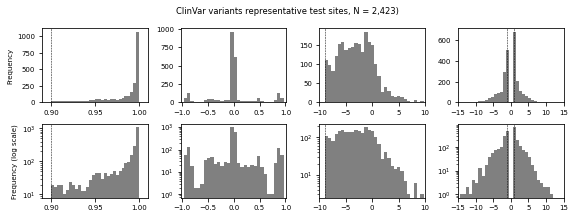

In [7]:
fig,ax = plt.subplots(2,4, figsize = (8,3))
ax = ax.T

for a in ax[0]:
    a.hist(clin_filt[['referenceClassprob','alternateClassprob']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = 0.9, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(0.05))
    a.set_xlim(0.89,1.01)

for a in ax[1]:
    a.hist(clin_filt['deltaClassification'], color = 'gray', bins = 30)
    a.xaxis.set_major_locator(MultipleLocator(0.5))
    a.set_xlim(-1.02,1.02)

for a in ax[2]:
    a.hist(clin_filt[['referenceStrength','alternateStrength']].max(axis = 1), color = 'gray', bins = 30)
    a.axvline(x = -9, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))
    a.set_xlim(-10,10)

for a in ax[3]:
    a.hist(clin_filt['deltaStrength'], color = 'gray', bins = 30)
    a.axvline(x = -1, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.axvline(x = +1, color = 'black', linestyle = 'dashed', linewidth = 0.5)
    a.xaxis.set_major_locator(MultipleLocator(5))
    a.set_xlim(-15,15)
    
for a in ax[:,1]:
    a.set_yscale('log')

ax[0][0].set_ylabel("Frequency")
ax[0][1].set_ylabel("Frequency (log scale)")

plt.suptitle(f"ClinVar variants representative test sites, N = {len(clin_filt):,d})")
plt.tight_layout()
plt.show()


In [8]:
print("\n### Extended/terminal exonic:")
print(f"Number of variant-pA test sites      {clin_filt_xte.shape[0]:6}")
print(f"Number of unique variants            {clin_filt_xte.variantID.nunique():6}")
print(f"Number of variants affecting >1 gene {(clin_filt_xte.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{clin_filt_xte.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{clin_filt_xte.directionEffect.value_counts()}")


print("\n### Intronic:")
print(f"Number of variant-pA test sites      {clin_filt_int.shape[0]:6}")
print(f"Number of unique variants            {clin_filt_int.variantID.nunique():6}")
print(f"Number of variants affecting >1 gene {(clin_filt_int.variantID.value_counts() > 1).sum():6}")

print(f"\nNumber of types of sites-\n{clin_filt_int.referenceFeature.value_counts()}")
print(f"\nDirection of effects on strength-\n{clin_filt_int.directionEffect.value_counts()}")



### Extended/terminal exonic:
Number of variant-pA test sites        1723
Number of unique variants              1680
Number of variants affecting >1 gene     29

Number of types of sites-
terminal_exon             1503
extended_terminal_exon     220
Name: referenceFeature, dtype: int64

Direction of effects on strength-
weakened        893
strengthened    830
Name: directionEffect, dtype: int64

### Intronic:
Number of variant-pA test sites         700
Number of unique variants               699
Number of variants affecting >1 gene      1

Number of types of sites-
intron:composite    611
intron:skipped       89
Name: referenceFeature, dtype: int64

Direction of effects on strength-
strengthened    387
weakened        313
Name: directionEffect, dtype: int64


#### Split variant representative sites by their effect on APA activity and save to BED files

In [9]:
test_bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'readsSlop', 'strand']

clin_filt['positionTest+1'] = clin_filt['positionTest']+1

clin_filt['label'] = clin_filt['variantID']
clin_filt['label'] = clin_filt['label'] + "|" + clin_filt['reference'] + ">" + clin_filt['alternate']
clin_filt['label'] = clin_filt['label'] + "|" + clin_filt['affectedMotif']
clin_filt['label'] = clin_filt['label'] + "|dID=" + clin_filt['deltaClassification'].round(3).astype(str) + "(" + clin_filt['referenceClassprob'].round(3).astype(str) + ">" + clin_filt['alternateClassprob'].round(3).astype(str) + ")"
clin_filt['label'] = clin_filt['label'] + "|dSTR=" + clin_filt['deltaStrengthProb'].round(3).astype(str) + "(" + clin_filt['referenceStrengthProb'].round(3).astype(str) + ">" + clin_filt['alternateStrengthProb'].round(3).astype(str) + ")"

clin_filt.loc[clin_filt['referenceFeature'] == 'intron:composite', 'label'] = clin_filt['label'] + "|dIC=" + (clin_filt['alternateICprob'] - clin_filt['referenceICprob']).round(3).astype(str) + "(" + clin_filt['referenceICprob'].round(3).astype(str) + ">" + clin_filt['alternateICprob'].round(3).astype(str) + ")"
clin_filt.loc[clin_filt['referenceFeature'] == 'intron:skipped', 'label'] = clin_filt['label'] + "|dIS=" + (clin_filt['alternateISprob'] - clin_filt['referenceISprob']).round(3).astype(str) + "(" + clin_filt['referenceISprob'].round(3).astype(str) + ">" + clin_filt['alternateISprob'].round(3).astype(str) + ")"

clin_filt['label'] = clin_filt['label'] + "|" + clin_filt['directionEffect']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    for direction in ['strengthened','weakened','mixed']:

        (clin_filt.loc[(clin_filt['strand'] == strand) & (clin_filt['directionEffect'] == direction), test_bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'clinvar.representative_sites.significant.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


#### Annotate clinical associations to variants and remove those with no disease relevance

In [10]:
clin_filt_long = clin_filt.explode('clinical_condition').reset_index(drop = True)
clin_filt_long['label'] = clin_filt_long['label'] + "|" + clin_filt_long['clinical_condition']

clin_filt_assoc = clin_filt_long.loc[~clin_filt_long['clinical_condition'].isin(['not_provided','not_specified'])].copy()
assoc_int = clin_filt_assoc.loc[clin_filt_assoc.referenceFeature.str.contains('intron')]
assoc_xte = clin_filt_assoc.loc[clin_filt_assoc.referenceFeature.str.contains('terminal_exon')]

print("\nDataset\t\tShape\t\tGenes Variants Combinations")
print(f"clin_filt      \t{clin_filt.shape}\t{clin_filt.gene.nunique():5} {clin_filt.variantID.nunique():8} {clin_filt.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"clin_filt_long \t{clin_filt_long.shape}\t{clin_filt_long.gene.nunique():5} {clin_filt_long.variantID.nunique():8} {clin_filt_long.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"clin_filt_assoc\t{clin_filt_assoc.shape}\t{clin_filt_assoc.gene.nunique():5} {clin_filt_assoc.variantID.nunique():8} {clin_filt_assoc.groupby(['variantID','gene']).size().shape[0]:12}")

print("\nClinically-associated variants split by genomic feature:")
print("Feature\t\tShape\t\tGenes Variants Combinations")
print(f"intronic       \t{assoc_int.shape}\t{assoc_int.gene.nunique():5} {assoc_int.variantID.nunique():8} {assoc_int.groupby(['variantID','gene']).size().shape[0]:12}")
print(f"terminal exonic\t{assoc_xte.shape}\t{assoc_xte.gene.nunique():5} {assoc_xte.variantID.nunique():8} {assoc_xte.groupby(['variantID','gene']).size().shape[0]:12}")



Dataset		Shape		Genes Variants Combinations
clin_filt      	(2423, 46)	 1206     2379         2423
clin_filt_long 	(3368, 46)	 1206     2379         2423
clin_filt_assoc	(2428, 46)	  879     1711         1751

Clinically-associated variants split by genomic feature:
Feature		Shape		Genes Variants Combinations
intronic       	(448, 46)	  187      306          307
terminal exonic	(1980, 46)	  752     1405         1444


In [11]:
clin_filt_assoc['clinical_condition'].value_counts()

Hereditary_cancer-predisposing_syndrome              94
Familial_adenomatous_polyposis_1                     35
Retinitis_pigmentosa                                 27
Familial_cancer_of_breast                            24
Hereditary_nonpolyposis_colorectal_neoplasms         21
                                                     ..
Leukoencephalopathy_with_vanishing_white_matter       1
Parkinson_Disease_Dominant/Recessive                  1
Macular_degeneration                                  1
Multicentric_osteolysis_nodulosis_and_arthropathy     1
Jervell_and_Lange-Nielsen_syndrome                    1
Name: clinical_condition, Length: 1117, dtype: int64

#### Create annotated VCF file of significant variants

In [12]:
filtered_ids = list(set(clin_filt_long['variantID'].tolist()))
print("# Included IDs:", len(filtered_ids))

annotation_to_add = {
    'representative_test_position'        : 'positionTest',
    'representative_test_position_feature': 'referenceFeature',
    'variant_distance_to_test_position'   : 'testSiteDistStranded',
    'variant_affected_motif_details'      : 'affectedMotifs',
    'variant_clinical_associations'       : 'clinical_condition',
    'variant_clinical_significance'       : 'clinical_significance',
    'ref_classification'                  : 'referenceClassprob',
    'alt_classification'                  : 'alternateClassprob',
    'ref_strength'                        : 'referenceStrength',
    'alt_strength'                        : 'alternateStrength',
    'ref_strength_probability'            : 'referenceStrengthProb',
    'alt_strength_probability'            : 'alternateStrengthProb',
    'ref_peak_clv_profile'                : 'referenceNormClvProfile',
    'alt_peak_clv_profile'                : 'alternateNormClvProfile',
    'ref_intron_composite_usage'          : 'referenceICprob',
    'alt_intron_composite_usage'          : 'alternateICprob',
    'ref_intron_skipped_usage'            : 'referenceISprob',
    'alt_intron_skipped_usage'            : 'alternateISprob',
    'delta_probability_classification'    : 'deltaClassification',
    'delta_probability_strength'          : 'deltaStrengthProb',
    'delta_logit_strength'                : 'deltaStrength',
}

vcf_te = os.path.join(CLINDIR, 'clinvar.pc.max_100.fully_within_xte.affected_motifs_sig_complete.vcf')
vcf_int = os.path.join(CLINDIR, 'clinvar.pc.max_100.fully_within_intron.affected_motifs_sig_complete.vcf')

vcf_te_reader  = vcf.Reader(open(vcf_te, 'r'))
vcf_int_reader = vcf.Reader(open(vcf_int, 'r'))

vcf_out1 = os.path.join(CLINDIR, 'clinvar.pc.max_100.fully_within_feature.affected_motifs_sig_complete.significant.vcf')
vcf_out1_writer = vcf.Writer(open(vcf_out1, 'w'), vcf_te_reader)

vcf_out2 = os.path.join(OUTDIR, 'clinvar.significant.vcf')
vcf_out2_writer = vcf.Writer(open(vcf_out2, 'w'), vcf_te_reader)

for record in tqdm.tqdm(vcf_te_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(clin_filt_long, f'{record.ID}', dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()
        
        
for record in tqdm.tqdm(vcf_int_reader):
    if (record.ID in filtered_ids):
        
        if (list(annotation_to_add.keys())[0] not in record.INFO.keys()):
            for k in annotation_to_add.keys():
                record.INFO[k] = []
            
        for k,dk in annotation_to_add.items():
            values = genetics.find_clinvar_attribute_value(clin_filt_long, f'{record.ID}', dk)
            genetics.add_annotation_attribute(record.INFO, k, values)
        
        vcf_out1_writer.write_record(record); vcf_out1_writer.flush()
        vcf_out2_writer.write_record(record); vcf_out2_writer.flush()

        
vcf_out1_writer.close()
vcf_out2_writer.close()
    

# Included IDs: 2379


102786it [00:46, 2215.96it/s]
172051it [00:34, 4979.66it/s]


#### Save overall table

In [13]:
out_cols = [
    'variantID',
    'chrom', 'position', 'reference', 'alternate',
    'gene', 'geneStrand', 'positionTest', 'testSiteDistStranded',
    'referenceFeature',
    'referenceClassprob', 'alternateClassprob', 'deltaClassification',
    'referenceStrength', 'alternateStrength', 'deltaStrength', 
    'referenceICprob', 'alternateICprob', 
    'referenceISprob', 'alternateISprob', 
    'affectedMotifs', 'clinical_significance','clinical_condition']

out_data = (clin_filt[out_cols]
            .drop_duplicates(subset = out_cols[:9])
            .sort_values(['chrom','positionTest'])
)

out_data.to_csv(os.path.join(OUTDIR, f'clinvar.representative_sites.significant.txt'), sep = "\t", index = False)
print(out_data.shape)


(2423, 23)


#### Make accompanying tracks

In [14]:
bed_cols = ['chrom', 'positionTest', 'positionTest+1', 'label', 'deltaStrength', 'strand']
bedgraph_cols = ['chrom','positionTest','positionTest+1']

for strand in ['+','-']:
    strand_str = "fwd" if (strand == "+") else "rev"
    
    strand_data = clin_filt_long.loc[clin_filt_long['strand'] == strand]
    
    (strand_data[bed_cols]
     .drop_duplicates()
     .sort_values(['chrom','positionTest'])
     .to_csv(os.path.join(OUTDIR, f'clinvar.significant.disease_assoc.{strand_str}.bed'), sep = "\t", index = False, header = False)
    )
    
    for score in ['referenceClassprob','alternateClassprob','referenceStrength','alternateStrength', 'referenceStrengthProb', 'alternateStrengthProb']:
        
        (strand_data[bedgraph_cols + [score]]
         .drop_duplicates()
         .sort_values(['chrom','positionTest'])
         .groupby(['chrom','positionTest','positionTest+1']).agg('max').reset_index()
         .to_csv(os.path.join(OUTDIR, f'clinvar.significant.disease_assoc.{score}.{strand_str}.bedgraph'), sep = "\t", index = False, header = False)
        )
        
    for direction in ['strengthened','weakened','mixed']:

        (strand_data.loc[strand_data['directionEffect'] == direction, bed_cols]
         .drop_duplicates()
         .to_csv(os.path.join(OUTDIR, f'clinvar.significant.disease_assoc.{direction}.{strand_str}.bed'), sep = "\t", index = False, header = False)
        )


## Analyze significant variants

### Variants affecting extended/terminal exonic sites

#### Visualize relationship between changes in PolyaID classification and PolyaStrength scores

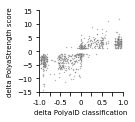

Corresponding metrics:
Pearson R- 1723 (0.7322537295734074, 1.9967276661636006e-289)


In [15]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

sns.scatterplot(data = clin_filt_xte, x = 'deltaClassification', y = 'deltaStrength',
                color = 'dimgray', s = 2, alpha = 0.5, rasterized = True, ax = ax)

ax.set_xlabel("delta PolyaID classification")
ax.set_ylabel("delta PolyaStrength score")

ax.set_xlim(-1,1)
ax.set_xticks(np.arange(-1,1.01,0.25))
ax.set_xticklabels(['-1.0','','-0.5','','0','','0.5','','1.0'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(5))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.xte.scatter.polyaid_vs_polyastrength.delta.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding metrics:")
print("Pearson R-", len(clin_filt_xte), st.pearsonr(clin_filt_xte['deltaClassification'], clin_filt_xte['deltaStrength']))


#### Visualize the distribution of variants around the representative test sites

In [16]:
paper_examples = ['617462','617458','617463',
                  '896666','302582','196038','1043148',
                  '35555','329889','1106650','344948']

extreme_values = []

clin_filt_xte['examples'] = np.nan
clin_filt_xte.loc[clin_filt_xte['variantID'].isin(extreme_values), 'examples'] = 'extreme'
clin_filt_xte.loc[clin_filt_xte['variantID'].isin(paper_examples), 'examples'] = 'paper'


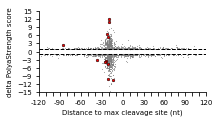

In [17]:
fig,ax = plt.subplots(1,1, figsize = (3,1.5))

ax.axhline(y = -1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.axhline(y = +1, color = 'black', linestyle = 'dashed', linewidth = 1)

sns.scatterplot(data = clin_filt_xte, x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'gray', edgecolor = None, s = 1, alpha = 0.75, ax = ax)

sns.scatterplot(data = clin_filt_xte.loc[(clin_filt_xte['examples'] == 'extreme')], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = None, s = 5, alpha = 1, ax = ax)

sns.scatterplot(data = clin_filt_xte.loc[(clin_filt_xte['examples'] == 'paper')],
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = 'black', linewidth = 0.5, s = 7, alpha = 1, ax = ax)

ax.set_xlim(-120,120)
ax.set_xticks(np.arange(-120,121,10))
ax.set_xticklabels(['-120','','','-90','','','-60','','','-30','','','0','','','30','','','60','','','90','','','120'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Distance to max cleavage site (nt)")
ax.set_ylabel("delta PolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.xte.change_strength_by_position.prob.repr.highlight.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


In [18]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength','examples']
clin_filt_xte.loc[clin_filt_xte['variantID'].isin(paper_examples), preview_cols].sort_values('testSiteDistStranded')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength,examples
229,896666,LRPPRC,"created_TGTA-Rich|TTGTAT,ATTGTA,TGTATT",-86,0.000004,2.263144,paper
1604,302582,SCN4B,"disrupted_TGTA-Rich|TTGTAT,ATTGTA,TGTATT",-37,-0.000119,-3.271526,paper
2638,617462,NAA10,disrupted_AATAAA|AATAAA,-25,-0.646313,-3.792884,paper
2637,617458,NAA10,disrupted_AATAAA|AATAAA,-24,-0.251476,-3.444041,paper
510,344948,ACVR2B,created_AATAAA|AATAAA,-23,0.510231,6.541848,paper
363,196038,SCN2A,created_AATAAA|AATAAA,-21,0.965398,5.263720,paper
2419,329889,PNKP,disrupted_AATAAA|AATAAA,-21,-0.231629,-10.270095,paper
2636,617463,NAA10,disrupted_AATAAA|AATAAA,-21,-0.897948,-4.735051,paper
1285,1043148,PLEC,created_AATAAA|AATAAA,-20,0.898700,11.911484,paper
149,1106650,TNNT2,created_AATAAA|AATAAA,-19,0.643895,10.966815,paper


#### Summarize the motifs affected by variants

In [19]:
clin_sum_dt = (
    assoc_xte.loc[assoc_xte['affectedMotifDirection'] != 'retained']
    [['variantID','affectedMotifDirection','affectedMotifFamily']]
    .drop_duplicates()
)

clin_sum = (clin_sum_dt
    .groupby(['affectedMotifFamily','affectedMotifDirection']).size()
    .reset_index().rename(columns = {0:'Count'})
)

clin_sum['Proportion'] = clin_sum['Count'] / clin_sum.groupby(['affectedMotifFamily'])['Count'].transform('sum')

print(clin_sum_dt.shape)
print(clin_sum_dt.variantID.nunique())
print(clin_sum['Count'].sum())


(1358, 3)
1346
1358


/home/esk863/.local/lib/python3.6/site-packages/pandas/core/indexing.py:961: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
notebook_setup.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  from sklearn.decomposition import PCA


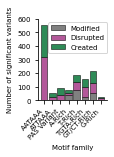

In [20]:
ordering = ['AATAAA','ATTAAA','PAS Variant','A-Rich','T-Rich','TGTA-Rich','GT/CT-Rich','G-Rich']

modified_props  = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'modified',  ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
disrupted_props = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'disrupted', ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
created_props   = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'created',   ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)

fig,ax = plt.subplots(1,1, figsize = (1.25,1.5))

plt.bar(ordering, modified_props, label = 'Modified', color = 'gray', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, disrupted_props, bottom = modified_props, label = 'Disrupted', color = '#B3589A', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, created_props, bottom = modified_props + disrupted_props, label = 'Created', color = 'seagreen', edgecolor = 'black', linewidth = 0.5)

ax.set_xticklabels(ordering, rotation = 45, ha = 'right', va = 'top')
ax.set_xlabel("Motif family")
ax.set_ylabel("Number of significant variants")

ax.set_ylim(0,600)
ax.yaxis.set_major_locator(MultipleLocator(100))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.xte.effect_by_family_by_direction.count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Summarize the clinical significance of significant variants

In [21]:
sig_ordering = ['Benign','Benign/Likely_benign','Likely_benign',
                'Uncertain_significance',
                'Likely_pathogenic','Pathogenic/Likely_pathogenic','Pathogenic',
                'Conflicting_interpretations_of_pathogenicity','Other']

clin_sig = assoc_xte[['variantID','clinical_significance']].drop_duplicates()

clin_sig['clin_sig'] = 'Other'
clin_sig.loc[clin_sig['clinical_significance'].isin(sig_ordering), 'clin_sig'] = clin_sig['clinical_significance']

clin_sig_sum = clin_sig.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"

print(clin_sig.shape)
print(clin_sig.variantID.nunique())
print(clin_sig_sum['count'].sum())


(1405, 3)
1405
1405


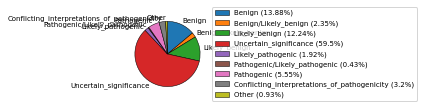

In [22]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(clin_sig_sum['prop'], 
                        labels = clin_sig_sum['clin_sig'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, clin_sig_sum['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, f'clinvar.xte.clinical_significance.percent_test_sites.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Does the distribution of clinical effects change if we use more stringent cutoffs?

In [23]:
sig_ordering = ['Benign','Benign/Likely_benign','Likely_benign',
                'Uncertain_significance',
                'Likely_pathogenic','Pathogenic/Likely_pathogenic','Pathogenic',
                'Conflicting_interpretations_of_pathogenicity','Other']

clin_sig = assoc_xte[['variantID','deltaStrength','directionEffect','clinical_significance']].drop_duplicates()

clin_sig['clin_sig'] = 'Other'
clin_sig.loc[clin_sig['clinical_significance'].isin(sig_ordering), 'clin_sig'] = clin_sig['clinical_significance']

clin_sig_sum = clin_sig.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"

print(clin_sig.shape)
print(clin_sig_sum['count'].sum())
print(clin_sig_sum)


(1419, 5)
1419
                                       clin_sig  count      prop  \
0                                        Benign    197  0.138830   
1                          Benign/Likely_benign     34  0.023961   
2                                 Likely_benign    175  0.123326   
3                        Uncertain_significance    840  0.591966   
4                             Likely_pathogenic     27  0.019027   
5                  Pathogenic/Likely_pathogenic      6  0.004228   
6                                    Pathogenic     79  0.055673   
7  Conflicting_interpretations_of_pathogenicity     46  0.032417   
8                                         Other     15  0.010571   

                                               label  
0                                    Benign (13.88%)  
1                        Benign/Likely_benign (2.4%)  
2                             Likely_benign (12.33%)  
3                     Uncertain_significance (59.2%)  
4                           L

### Variants affecting intronic sites

#### Visualize the distribution of variants around the representative test sites

In [24]:
paper_examples = ['1248002']
extreme_values = ['1281655','125744','1243139','1271412',
                  '746304','1126993','915624','335197']

clin_filt_int['examples'] = np.nan
clin_filt_int.loc[clin_filt_int['variantID'].isin(extreme_values), 'examples'] = 'extreme'
clin_filt_int.loc[clin_filt_int['variantID'].isin(paper_examples), 'examples'] = 'paper'


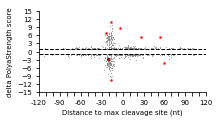

In [25]:
fig,ax = plt.subplots(1,1, figsize = (3,1.5))

ax.axhline(y = -1, color = 'black', linestyle = 'dashed', linewidth = 1)
ax.axhline(y = +1, color = 'black', linestyle = 'dashed', linewidth = 1)

sns.scatterplot(data = clin_filt_int, x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'gray', edgecolor = None, s = 1, alpha = 0.75, ax = ax)

sns.scatterplot(data = clin_filt_int.loc[(clin_filt_int['examples'] == 'extreme')], 
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = None, s = 5, alpha = 1, ax = ax)

sns.scatterplot(data = clin_filt_int.loc[(clin_filt_int['examples'] == 'paper')],
                x = 'testSiteDistStranded', y = 'deltaStrength', 
                color = 'red', edgecolor = 'black', linewidth = 0.5, s = 7, alpha = 1, ax = ax)

ax.set_xlim(-120,120)
ax.set_xticks(np.arange(-120,121,10))
ax.set_xticklabels(['-120','','','-90','','','-60','','','-30','','','0','','','30','','','60','','','90','','','120'])

ax.set_ylim(-15,15)
ax.yaxis.set_major_locator(MultipleLocator(3))

ax.set_xlabel("Distance to max cleavage site (nt)")
ax.set_ylabel("delta PolyaStrength score")

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.int.change_strength_by_position.prob.repr.highlight.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


In [26]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength','examples']
clin_filt_int.loc[clin_filt_int['variantID'].isin(paper_examples), preview_cols].sort_values('deltaStrength')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength,examples
3874,1248002,RUNX1,disrupted_AATAAA|AATAAA,-21,-0.091454,-2.742887,paper


In [27]:
preview_cols = ['variantID','gene','affectedMotifs','testSiteDistStranded','deltaClassification','deltaStrength']
clin_filt_int.loc[clin_filt_int['variantID'].isin(extreme_values), preview_cols].sort_values('deltaStrength')


,variantID,gene,affectedMotifs,testSiteDistStranded,deltaClassification,deltaStrength
2926,335197,NDUFA10,disrupted_AATAAA|AATAAA,-17,-0.443446,-10.610773
3710,1281655,VPS13C,"modified_GT/CT-Rich|TGTGTG,GTGTGT,TGTGTT,GTGTTT",59,-0.000005,-4.287687
2842,746304,LRP2,"modified_T-Rich|TCTTTT,TTTTTC,TTTTCT,TTTCTT,TT...",54,-0.000212,5.194747
3782,125744,BRCA1,"disrupted_GT/CT-Rich|CTCTGC,TCTGCT",26,0.288328,5.485169
3693,915624,FBN1,created_AATAAA|AATAAA,-24,0.202596,6.974662
3133,1243139,PKHD1,created_AATAAA|AATAAA,-4,0.966113,8.523729
2937,1271412,KAT2B,created_AATAAA|AATAAA,-17,0.897484,10.965422


#### Summarize the motifs affected by variants

In [37]:
clin_sum_dt = (
    assoc_int.loc[assoc_int['affectedMotifDirection'] != 'retained']
    [['variantID','affectedMotifDirection','affectedMotifFamily']]
    .drop_duplicates()
)

clin_sum = (clin_sum_dt
    .groupby(['affectedMotifFamily','affectedMotifDirection']).size()
    .reset_index().rename(columns = {0:'Count'})
)

clin_sum['Proportion'] = clin_sum['Count'] / clin_sum.groupby(['affectedMotifFamily'])['Count'].transform('sum')

print(clin_sum_dt.shape)
print(clin_sum_dt.variantID.nunique())
print(clin_sum['Count'].sum())


(297, 3)
297
297


notebook_setup.py:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  from sklearn.decomposition import PCA


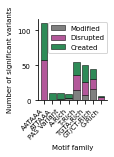

In [38]:
ordering = ['AATAAA','ATTAAA','PAS Variant','A-Rich','T-Rich','TGTA-Rich','GT/CT-Rich','G-Rich']

modified_props  = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'modified',  ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
disrupted_props = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'disrupted', ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)
created_props   = clin_sum.loc[clin_sum['affectedMotifDirection'] == 'created',   ['affectedMotifFamily','Count']].set_index('affectedMotifFamily').loc[ordering, 'Count'].fillna(0)

fig,ax = plt.subplots(1,1, figsize = (1.25,1.5))

plt.bar(ordering, modified_props, label = 'Modified', color = 'gray', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, disrupted_props, bottom = modified_props, label = 'Disrupted', color = '#B3589A', edgecolor = 'black', linewidth = 0.5)
plt.bar(ordering, created_props, bottom = modified_props + disrupted_props, label = 'Created', color = 'seagreen', edgecolor = 'black', linewidth = 0.5)

ax.set_xticklabels(ordering, rotation = 45, ha = 'right', va = 'top')
ax.set_xlabel("Motif family")
ax.set_ylabel("Number of significant variants")

ax.set_ylim(0,None)
ax.yaxis.set_major_locator(MultipleLocator(50))

ax.legend(bbox_to_anchor = (1.05,1))

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig(os.path.join(OUTDIR, 'clinvar.int.effect_by_family_by_direction.count.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


#### Summarize the clinical significance of significant variants

In [30]:
sig_ordering = ['Benign','Benign/Likely_benign','Likely_benign',
                'Uncertain_significance',
                'Likely_pathogenic','Pathogenic/Likely_pathogenic','Pathogenic',
                'Conflicting_interpretations_of_pathogenicity','Other']

clin_sig = assoc_int[['variantID','clinical_significance']].drop_duplicates()

clin_sig['clin_sig'] = 'Other'
clin_sig.loc[clin_sig['clinical_significance'].isin(sig_ordering), 'clin_sig'] = clin_sig['clinical_significance']

clin_sig_sum = clin_sig.groupby(['clin_sig']).size().loc[sig_ordering].reset_index().rename(columns = {0:'count'})
clin_sig_sum['prop']  = clin_sig_sum['count'] / clin_sig_sum['count'].sum()
clin_sig_sum['label'] = clin_sig_sum['clin_sig'] + " (" + (clin_sig_sum['prop']*100).round(2).astype(str) + "%)"

print(clin_sig.shape)
print(clin_sig_sum['count'].sum())


(306, 3)
306


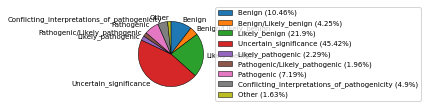

Corresponding data:
                                       clin_sig  count      prop
0                                        Benign     32  0.104575
1                          Benign/Likely_benign     13  0.042484
2                                 Likely_benign     67  0.218954
3                        Uncertain_significance    139  0.454248
4                             Likely_pathogenic      7  0.022876
5                  Pathogenic/Likely_pathogenic      6  0.019608
6                                    Pathogenic     22  0.071895
7  Conflicting_interpretations_of_pathogenicity     15  0.049020
8                                         Other      5  0.016340


In [31]:
fig,ax = plt.subplots(1,1, figsize = (1.5,1.5))

wedges, texts = plt.pie(clin_sig_sum['prop'], 
                        labels = clin_sig_sum['clin_sig'],
                        startangle = 90, counterclock = False,
                        wedgeprops = {'linewidth' : 0.5, 'edgecolor' : 'black'}
                       )

ax.legend(wedges, clin_sig_sum['label'],
          title="",
          loc="center left",
          bbox_to_anchor=(1, 0, 0.5, 1))

plt.savefig(os.path.join(OUTDIR, f'clinvar.int.clinical_significance.percent_test_sites.svg'), format = 'svg', dpi = 600, transparent = True)
plt.show()


print("Corresponding data:")
print(clin_sig_sum[['clin_sig','count','prop']])


#### Examples of disease-relevant variants and genes


##########
NAA10

Associated conditions-	 Microphthalmia_syndromic_1 

1
variantID                                    617462
chrom                                             X
position                                  153929948
strand                                            -
reference                                         T
alternate                                         C
gene                                          NAA10
geneStrand                                        -
affectedMotif                disrupted_AATAAA_NAA10
positionTest                              153929923
testSiteDistStranded                            -25
referenceFeature                      terminal_exon
referenceClassprob                         0.999049
alternateClassprob                         0.352736
deltaClassification                       -0.646313
referenceStrength                         0.0148703
alternateStrength                          -3.77801
deltaStrength                             

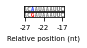


##########
NAA10

Associated conditions-	 Microphthalmia_syndromic_1 

2
variantID                                                      617458
chrom                                                               X
position                                                    153929947
strand                                                              -
reference                                                           T
alternate                                                           C
gene                                                            NAA10
geneStrand                                                          -
affectedMotif                                  disrupted_AATAAA_NAA10
positionTest                                                153929923
testSiteDistStranded                                              -24
referenceFeature                                        terminal_exon
referenceClassprob                                           0.999049
alternateClasspr

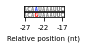


##########
NAA10

Associated conditions-	 Microphthalmia_syndromic_1 

1
variantID                                    617463
chrom                                             X
position                                  153929944
strand                                            -
reference                                         T
alternate                                         C
gene                                          NAA10
geneStrand                                        -
affectedMotif                disrupted_AATAAA_NAA10
positionTest                              153929923
testSiteDistStranded                            -21
referenceFeature                      terminal_exon
referenceClassprob                         0.999049
alternateClassprob                         0.101102
deltaClassification                       -0.897948
referenceStrength                         0.0148703
alternateStrength                          -4.72018
deltaStrength                             

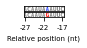


##########
LRPPRC

Associated conditions-	 Congenital_lactic_acidosis_Saguenay-Lac-Saint-Jean_type 

1
variantID                                                           896666
chrom                                                                    2
position                                                          43886311
strand                                                                   -
reference                                                                T
alternate                                                                A
gene                                                                LRPPRC
geneStrand                                                               -
affectedMotif                                        created_TTGTAT_LRPPRC
positionTest                                                      43886225
testSiteDistStranded                                                   -86
referenceFeature                                             terminal_e

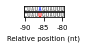


##########
SCN4B

Associated conditions-	 Congenital_long_QT_syndrome
			Long_QT_syndrome 

2
variantID                                                  302582
chrom                                                          11
position                                                118133415
strand                                                          -
reference                                                  AAATAC
alternate                                                       A
gene                                                        SCN4B
geneStrand                                                      -
affectedMotif                              disrupted_TTGTAT_SCN4B
positionTest                                            118133378
testSiteDistStranded                                          -37
referenceFeature                                    terminal_exon
referenceClassprob                                       0.999498
alternateClassprob                             

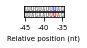


##########
SCN2A

Associated conditions-	 Early_infantile_epileptic_encephalopathy_11
			Seizures_benign_familial_infantile_3 

4
variantID                                                      196038
chrom                                                               2
position                                                    165389311
strand                                                              +
reference                                                           C
alternate                                                           T
gene                                                            SCN2A
geneStrand                                                          +
affectedMotif                                    created_AATAAA_SCN2A
positionTest                                                165389333
testSiteDistStranded                                              -21
referenceFeature                                        terminal_exon
referenceClassprob           

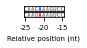


##########
PLEC

Associated conditions-	 Epidermolysis_bullosa_simplex_Ogna_type
			Epidermolysis_bullosa_simplex_with_muscular_dystrophy
			Epidermolysis_bullosa_simplex_with_nail_dystrophy
			Epidermolysis_bullosa_simplex_with_pyloric_atresia
			Limb-girdle_muscular_dystrophy_type_2Q 

5
variantID                                                1043148
chrom                                                          8
position                                               143920686
strand                                                         -
reference                                                      C
alternate                                                      A
gene                                                        PLEC
geneStrand                                                     -
affectedMotif                                created_AATAAA_PLEC
positionTest                                           143920666
testSiteDistStranded                                      

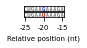


##########
TP53

Associated conditions-	 Basal_cell_carcinoma_susceptibility_to_7
			Hereditary_cancer-predisposing_syndrome
			Li-Fraumeni_syndrome_1 

3
variantID                                                       35555
chrom                                                              17
position                                                      7668434
strand                                                              -
reference                                                           T
alternate                                                           G
gene                                                             TP53
geneStrand                                                          -
affectedMotif                                   disrupted_AATAAA_TP53
positionTest                                                  7668420
testSiteDistStranded                                              -14
referenceFeature                                        terminal_exon
refe

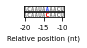


##########
PNKP

Associated conditions-	 Early_infantile_epileptic_encephalopathy_10 

1
variantID                                                     329889
chrom                                                             19
position                                                    49861225
strand                                                             -
reference                                                          T
alternate                                                          G
gene                                                            PNKP
geneStrand                                                         -
affectedMotif                                 disrupted_TTTATT_PTOV1
positionTest                                                49861204
testSiteDistStranded                                             -21
referenceFeature                                       terminal_exon
referenceClassprob                                          0.999944
alternateClas

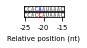


##########
RUNX1

Associated conditions-	 Familial_platelet_disorder_with_associated_myeloid_malignancy 

1
variantID                                                           934627
chrom                                                                   21
position                                                          34892925
strand                                                                   -
reference                                                                C
alternate                                                                A
gene                                                                 RUNX1
geneStrand                                                               -
affectedMotif                                         created_CTGTAT_RUNX1
positionTest                                                      34892876
testSiteDistStranded                                                   -49
referenceFeature                                          intron:c

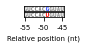


##########
TNNT2

Associated conditions-	 Familial_hypertrophic_cardiomyopathy_2
			Familial_restrictive_cardiomyopathy_3
			Left_ventricular_noncompaction_6 

3
variantID                                               1106650
chrom                                                         1
position                                              201359210
strand                                                        -
reference                                                     C
alternate                                                     T
gene                                                      TNNT2
geneStrand                                                    -
affectedMotif                              created_AATAAA_TNNT2
positionTest                                          201359191
testSiteDistStranded                                        -19
referenceFeature                                  terminal_exon
referenceClassprob                                     0.355098
alter

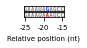


##########
ACVR2B

Associated conditions-	 Heterotaxia 

1
variantID                                344948
chrom                                         3
position                               38484904
strand                                        +
reference                               TAGAGAA
alternate                                     T
gene                                     ACVR2B
geneStrand                                    +
affectedMotif             created_AATAAA_ACVR2B
positionTest                           38484933
testSiteDistStranded                        -23
referenceFeature                  terminal_exon
referenceClassprob                     0.488345
alternateClassprob                     0.998576
deltaClassification                    0.510231
referenceStrength                      -6.48093
alternateStrength                     0.0609201
deltaStrength                           6.54185
referenceStrengthProb                 0.0110716
alternateStrengthProb       

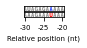

In [32]:
example_cols = ['variantID', 'chrom', 'position', 'strand', 'reference', 'alternate',
                'gene', 'geneStrand', 'affectedMotif', 'positionTest', 'testSiteDistStranded','referenceFeature',
                'referenceClassprob', 'alternateClassprob','deltaClassification',
                'referenceStrength', 'alternateStrength', 'deltaStrength',
                'referenceStrengthProb', 'alternateStrengthProb', 'deltaStrengthProb',
                'referenceICprob', 'alternateICprob', 'referenceISprob', 'alternateISprob',
                'affectedMotifs', 'clinical_condition',
                'clinical_significance']

example_ids = ['617462','617458','617463','896666','302582','196038','1043148','35555','329889','934627','1106650','344948']
example_gene = ['NAA10','NAA10','NAA10','LRPPRC','SCN4B','SCN2A','PLEC','TP53','PNKP','RUNX1','TNNT2','ACVR2B']
example_range = [(120-27,120-17+1),(120-27,120-17+1),(120-27,120-17+1),(120-90,120-80+1),(120-45, 120-35+1),(120-25, 120-15+1),(120-25, 120-15+1),(120-20, 120-10+1),(120-25, 120-15+1),(120-55, 120-45+1),(120-25, 120-15+1),(120-30, 120-20+1)]

for eid, egene, erange in zip(example_ids, example_gene, example_range):
    print(f"\n##########\n{egene}")
    print("\nAssociated conditions-\t", "\n\t\t\t".join(sorted(set(clin_filt_long.loc[(clin_filt_long['variantID'] == eid) & (~clin_filt_long['clinical_condition'].isin(['not_provided','not_specified'])), 'clinical_condition'].tolist()))), "\n")
    print((clin_filt_long['variantID'] == eid).sum())
    print(clin_filt_long.loc[clin_filt_long['variantID'] == eid].iloc[0][example_cols])
    
    e_name = f'clinvar.{eid}.{egene}'
    e_data = clin_filt_long.loc[(clin_filt_long['variantID'] == eid) & (clin_filt_long['gene'] == egene)].iloc[0]

    genetics.plot_variant_logo(os.path.join(OUTDIR, f'variant_examples.clinvar.{e_name}.svg'),
                               e_data['referenceSequence'], e_data['alternateSequence'], 
                               erange, [120+e_data['testSiteDistStranded']])
    

## Benchmark Examples

In [33]:
benchmark_cols = ['variantID', 'chrom', 'position', 'strand', 'reference', 'alternate',
                  'gene', 'geneStrand', 'affectedMotif', 'positionTest', 'testSiteDistStranded','referenceFeature',
                  'referenceClassprob', 'alternateClassprob','deltaClassification',
                  'referenceStrength', 'alternateStrength', 'deltaStrength',
                  'referenceStrengthProb', 'alternateStrengthProb', 'deltaStrengthProb',
                  'referenceICprob', 'alternateICprob', 'referenceISprob', 'alternateISprob',
                  'readsExact', 'readsSlop', 'directionEffect', 'affectedMotifs', 'clinical_condition',
                  'clinical_significance']

benchmark_ids = ['35555', '375749', '15647','65581']
benchmark_gene = ['TP53','HBA2v1','HBA2v2','INS']

for bid, bgene in zip(benchmark_ids, benchmark_gene):
    print(f"\n##########\n{bgene}")
    print("\nAssociated conditions-\t", "\n\t\t\t".join(sorted(set(clin_filt_long.loc[clin_filt_long['variantID'] == bid, 'clinical_condition'].tolist()))), "\n")
    print(clin_filt_long.loc[clin_filt_long['variantID'] == bid].iloc[0][benchmark_cols])
    


##########
TP53

Associated conditions-	 Basal_cell_carcinoma_susceptibility_to_7
			Hereditary_cancer-predisposing_syndrome
			Li-Fraumeni_syndrome_1 

variantID                                                       35555
chrom                                                              17
position                                                      7668434
strand                                                              -
reference                                                           T
alternate                                                           G
gene                                                             TP53
geneStrand                                                          -
affectedMotif                                   disrupted_AATAAA_TP53
positionTest                                                  7668420
testSiteDistStranded                                              -14
referenceFeature                                        terminal_exon
refere

/home/esk863/.local/lib/python3.6/site-packages/pandas/core/series.py:1152: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self.loc[key]
